# Amazon Sagemakerを利用したきのこの山検出AIの実装研修

## 研修のゴール共有
たけのこの里ときのこの山の何れかがベルトコンベアーで流れて来たときに、物体を認識させきのこの山を検出する。

## 目次

1. モデル学習用の画像を撮影する
    * S3バケットの確認
    * 写真撮影及び画像のアップロード
2. 画像にラベリングを行い学習させるインプットを整備する
    * S3バケットへ画像の格納
    * ラベリングを実施
    * ラベリング結果をモデル作成用に加工
3. FineTuneを利用し、学習インプットにてモデルの作成を行う
    * 学習用インプットデータを指定してモデルの作成を実施
4. モデルを起動する
    * 作成モデルを起動
5. 起動したモデルにてテスト判定を行う
    * エンドポイントを利用しテストイメージで判定させる
6. 疑似ベルトコンベアープログラムで判定させる
    * 完成したモデルを利用し最終テストを行う

## 1. モデル学習用の画像を撮影する
### S3バケットの確認
ユーザー毎に作成されている、S3バケットが存在している事を確認する

### 写真撮影及び画像のアップロード
スマホにて画像撮影を実施し、該当イメージをアップロードする

## 2.画像にラベリングを行い学習させるインプットを整備する
* ラベリングチームの作成
グループメンバーにてラベリングチームを作成する


In [ ]:
!apt-get update && apt-get upgrade -y
!apt-get install libgl1-mesa-dev -y
!pip install boto3
!pip install opencv-python

import sagemaker, json, numpy as np, os, boto3, uuid
from PIL import Image, ImageDraw, ImageOps, ImageColor, ImageFont
import matplotlib.patches as patches
from matplotlib import pyplot as plt
from glob import glob
import cv2
np.random.seed(seed=1234)

In [6]:
BUCKET_NAME = "training-user1-s3"
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(BUCKET_NAME)

In [ ]:
OUTPUT_MANIFEST_PATH = "kinotake/images/kinotake-user1/manifests/output/output.manifest"
output_manifest_object = my_bucket.Object(OUTPUT_MANIFEST_PATH)
output_manifest_json = output_manifest_object.get()["Body"].read().decode('utf-8').split()


OUTPUT_PATH = "kinotake/annotations.json"


# 結果のきのこの山やたけのこの里の位置情報を格納する辞書 
annotation_dict = {
    'images':[],
    'annotations':[]
}

# 画像のファイル名に使う一意なシーケンス番号
IMAGE_ID = 0

# ラベリング結果の行数分ループする
# ラベリング結果は 1 行につき 1 画像格納される
for manifest_line in output_manifest_json:
    # 画像のラベリング結果の読み込み
    manifest_dict = json.loads(manifest_line)
    # print(manifest_dict)
    # 画像のファイル名取得(ラベリング結果に格納されている)
    filename = manifest_dict['source-ref'].split('/')[-1]
    annotation_list = manifest_dict['kinotake-user1']['annotations']
    # print(annotation_list)
    # ラベリング結果を出力用辞書に格納
    annotation_dict['images'].append(
        {
            'file_name' : filename,
            'height' : manifest_dict['kinotake-user1']['image_size'][0]['height'],
            'width' : manifest_dict['kinotake-user1']['image_size'][0]['width'],
            'id' : IMAGE_ID
        }
    )
    for annotation in annotation_list:
        # 座標変換
        left = annotation['left']
        top = annotation['top']
        right = annotation['left'] + annotation['width']
        bottom = annotation['top'] + annotation['height']
        # アノテーションを編集
        annotation_dict['annotations'].append(
            {
                'image_id': IMAGE_ID,
                'bbox': [left, top, right, bottom],
                # 文字列へ変換し格納
                # 'category_id': manifest_dict['kinotake-user1-metadata']['class-map'][str(annotation['class_id'])]
                'category_id': annotation['class_id']
            }
        )
    
    IMAGE_ID += 1
    
# print(json.dumps(annotation_dict))

# # ランダムクロップ補正後のラベリング結果を出力
# with open('annotations.json','wt') as f:
#     f.write(json.dumps(annotation_dict))  
obj = s3.Object(BUCKET_NAME, OUTPUT_PATH)
obj.put(Body = json.dumps(annotation_dict, ensure_ascii=False)) #←変数をJSON変換し S3にPUTする

In [100]:
# 推論エンドポイントにアクセスするための sagemaker-runtime クライアントの生成
smr_client = boto3.client('sagemaker-runtime')
# エンドポイントの名前
ENDPOINT_NAME='jumpstart-ftc-user1-kinotake-endpoint'
# 推論する画像の場所
TEST_IMAGE_FILE = 'test_raw_images/lattice.jpg'

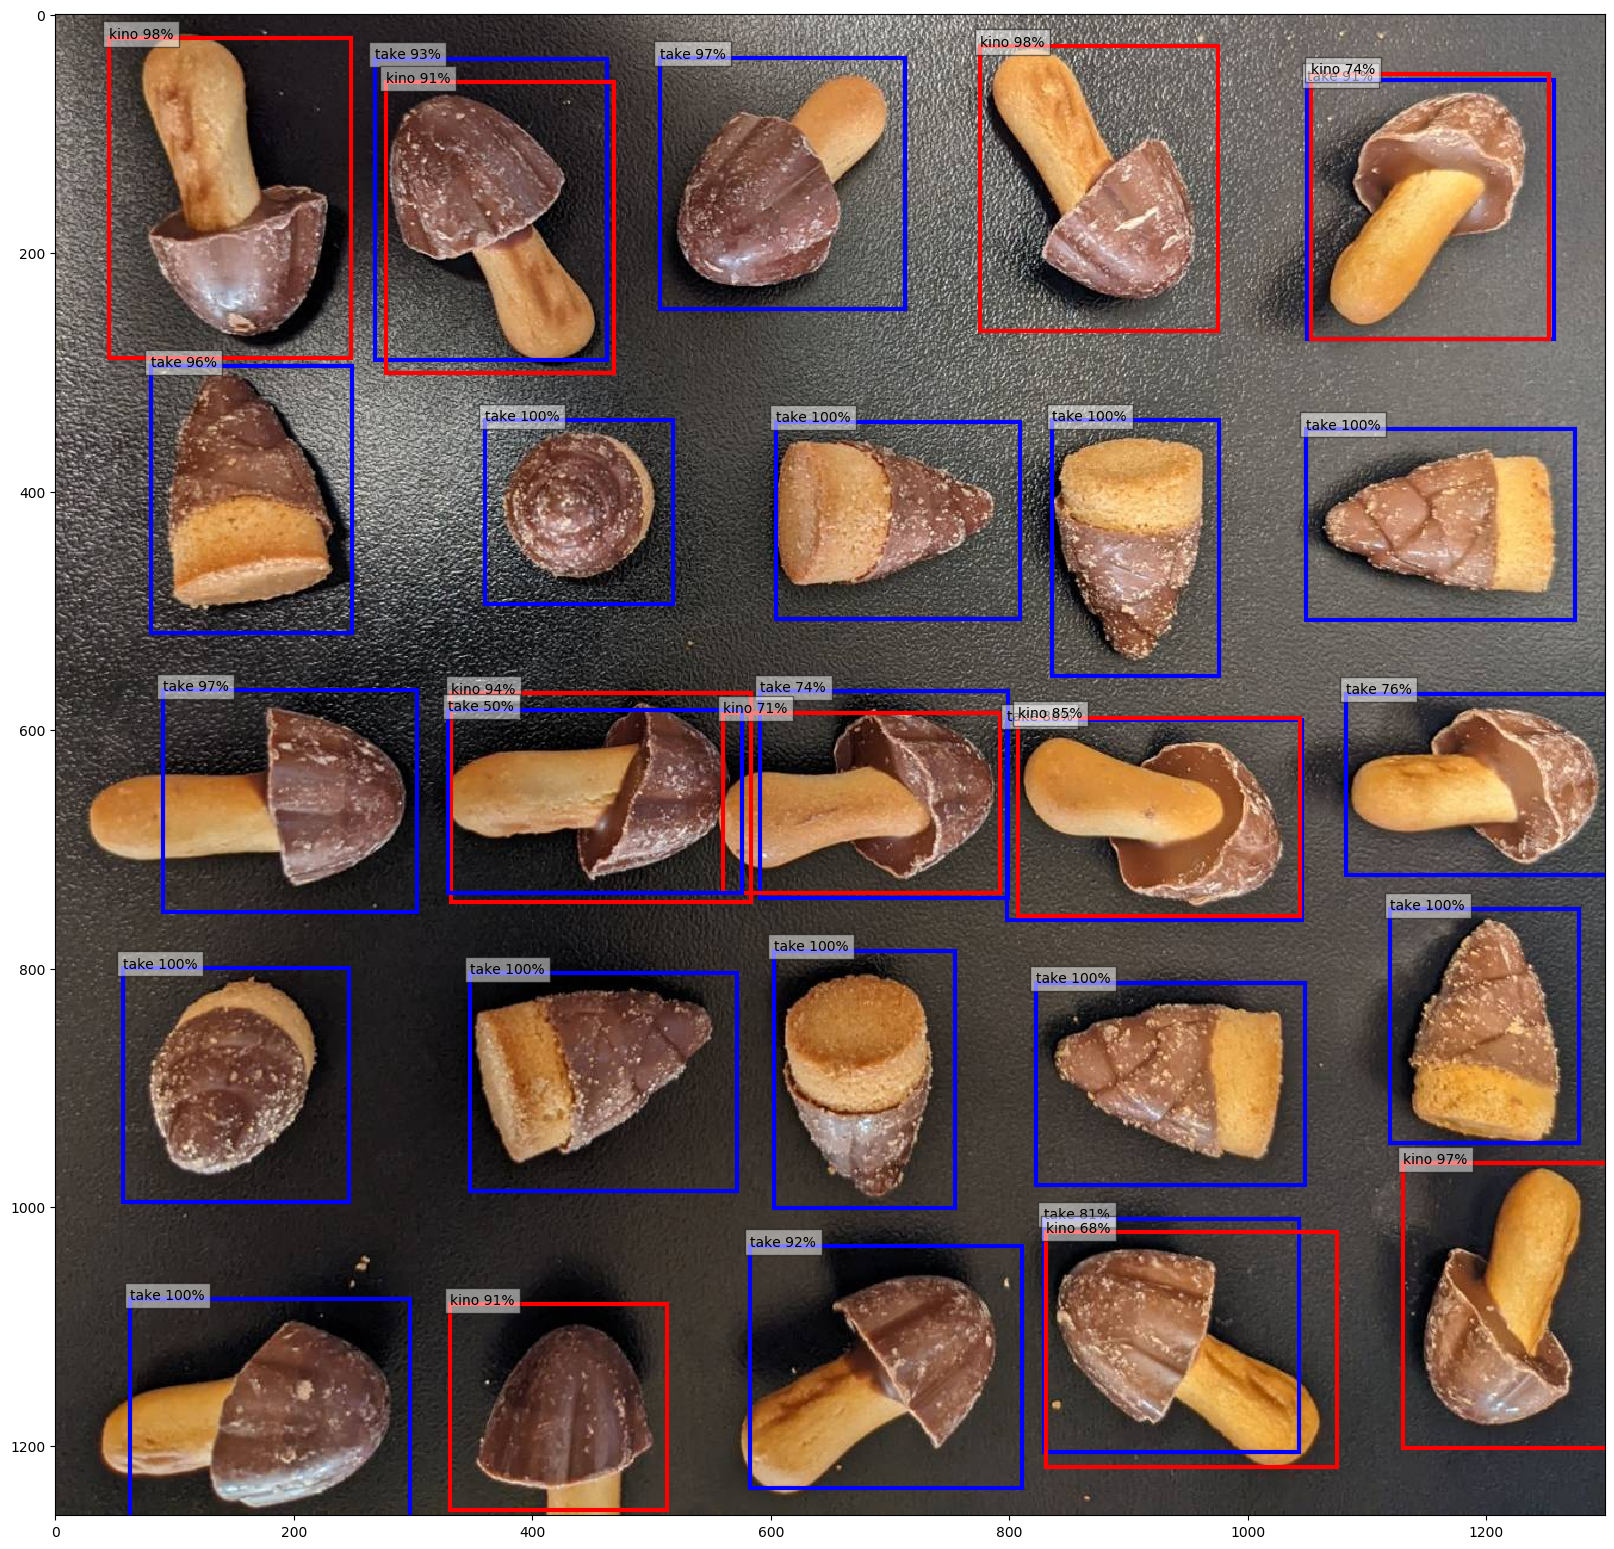

In [101]:
# 推論対象の画像を開いて変数に格納
with open(TEST_IMAGE_FILE, 'rb') as f:
    img_bin = f.read()

# 推論を実行
response = smr_client.invoke_endpoint(EndpointName=ENDPOINT_NAME, ContentType='application/x-image', Body=img_bin)

# 推論結果を読み込む
model_predictions = json.loads(response['Body'].read())
# 結果を可視化
# テスト画像を PIL を通して numpy array として開く
image_np = np.array(Image.open(TEST_IMAGE_FILE))
# matplotlibで描画する
fig = plt.figure(figsize=(20,20))
ax = plt.axes()
ax.imshow(image_np)
# 推論結果を変数に展開
bboxes, classes, confidences = model_predictions['normalized_boxes'], model_predictions['classes'], model_predictions['scores']
# 物体検出結果を検出した分だけループする
for idx in range(len(bboxes)):
    # 信頼度スコアが 0.5 以上のみ可視化する
    if confidences[idx]>0.5:
        # 検出した座標（左上を(0,0),右下を(1,1)とした相対座標)を取得
        left, bot, right, top = bboxes[idx]
        # 相対座標を絶対座標に変換する
        x, w = [val * image_np.shape[1] for val in [left, right - left]]
        y, h = [val * image_np.shape[0] for val in [bot, top - bot]]
        # 検出した物体の ID を take/kino に読み替える
        class_name = 'kino' if int(classes[idx])==0 else 'take'
        # take/kinoに対して矩形で描画するための色を設定する
        color = 'blue' if class_name == 'take' else 'red'
        # matplotlib に検出した物体に矩形を描画する
        rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        # 左上に検出結果と信頼度スコアを描画する
        ax.text(x, y, "{} {:.0f}%".format(class_name, confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
fig

In [80]:
for manifest_line in output_manifest_json:
    # 画像のラベリング結果の読み込み
    manifest_dict = json.loads(manifest_line)
    print(manifest_dict['source-ref'])

s3://training-user1-s3/kinotake/images/0DF78C49-911D-492D-8B8C-88CD43D06FE6_1_105_c.jpeg
s3://training-user1-s3/kinotake/images/1DD62421-2F52-4C08-AE04-54040AA60D0A_1_105_c.jpeg
s3://training-user1-s3/kinotake/images/21BFC9DB-0B51-4AEA-BB83-9707BF5D20C0_1_105_c.jpeg
s3://training-user1-s3/kinotake/images/2628BDDB-391A-458F-9716-3026E3DD1483_1_105_c.jpeg
s3://training-user1-s3/kinotake/images/32928BBF-99B8-4F05-ACB6-2599C9554A63_1_105_c.jpeg
s3://training-user1-s3/kinotake/images/35943BA3-FE61-40B3-8CFB-62E81EC35190_1_105_c.jpeg
s3://training-user1-s3/kinotake/images/54E091F3-CC07-4927-BB6B-251B47DFDD17_1_105_c.jpeg
s3://training-user1-s3/kinotake/images/6245E727-2589-419E-81D6-650E6330B9D2_1_105_c.jpeg
s3://training-user1-s3/kinotake/images/6D762E68-BBA3-4722-8B25-32EE93127A90_1_105_c.jpeg
s3://training-user1-s3/kinotake/images/7E2DD0D0-5874-4CE6-9639-5328CF3A2770_1_105_c.jpeg
s3://training-user1-s3/kinotake/images/7EB5F64A-DC82-4167-B31D-7F2D61067143_1_105_c.jpeg
s3://training-user1-s

In [29]:
# S3 からマニフェストファイルをLocal（manifestフォルダ）へダウンロード
LOCAL_MANIFEST_DIR = "./training-manifest/"
BASE_PREFIX = "kinotake/images"
GT_JOB_NAME = "kinotake-user1"
sagemaker.session.Session().download_data(LOCAL_MANIFEST_DIR, key_prefix=f'{BASE_PREFIX}/{GT_JOB_NAME}/manifests/output/output.manifest',bucket=BUCKET_NAME)


In [36]:
# S3 からLocalへラベリング済みデータのダウンロード
TRAIN_RAWIMAGE_DIR = './training-train_raw_images/'
import shutil
shutil.rmtree(TRAIN_RAWIMAGE_DIR)
os.mkdir(TRAIN_RAWIMAGE_DIR)

# ラベリング結果をテキストとして読み込む
with open(f'{LOCAL_MANIFEST_DIR}/output.manifest','r') as f:
    manifest_line_list = f.readlines()

for manifest_line in manifest_line_list:
    # 画像のラベリング結果の読み込み
    manifest_dict = json.loads(manifest_line)
    filename = manifest_dict['source-ref'].split('/')[-1]
    print(filename)
    sagemaker.session.Session().download_data(TRAIN_RAWIMAGE_DIR, key_prefix=f'{BASE_PREFIX}/{filename}',bucket=BUCKET_NAME)


0DF78C49-911D-492D-8B8C-88CD43D06FE6_1_105_c.jpeg
1DD62421-2F52-4C08-AE04-54040AA60D0A_1_105_c.jpeg
21BFC9DB-0B51-4AEA-BB83-9707BF5D20C0_1_105_c.jpeg
2628BDDB-391A-458F-9716-3026E3DD1483_1_105_c.jpeg
32928BBF-99B8-4F05-ACB6-2599C9554A63_1_105_c.jpeg
35943BA3-FE61-40B3-8CFB-62E81EC35190_1_105_c.jpeg
54E091F3-CC07-4927-BB6B-251B47DFDD17_1_105_c.jpeg
6245E727-2589-419E-81D6-650E6330B9D2_1_105_c.jpeg
6D762E68-BBA3-4722-8B25-32EE93127A90_1_105_c.jpeg
7E2DD0D0-5874-4CE6-9639-5328CF3A2770_1_105_c.jpeg
7EB5F64A-DC82-4167-B31D-7F2D61067143_1_105_c.jpeg
A4179EAC-F030-44BB-A58F-2866B3CF46E8_1_105_c.jpeg
AB8B98C4-9566-4175-8F99-82AB9FA5D53B_1_105_c.jpeg
ABC6CDC5-BA64-4891-9EAF-0F5EA576D73E_1_105_c.jpeg
BF1A5D3C-23E2-4776-9C07-1E17E438C74A_1_105_c.jpeg
C0F96AF6-D22D-4E91-8B33-0F3A91FF9AE0_1_105_c.jpeg
D9684E86-16B6-446F-8E1E-D0C9BBE7BDC8_1_105_c.jpeg
DD42E66C-7C87-498A-B7B3-888EBA11E10F_1_105_c.jpeg
ED0DD042-84DB-46F6-B062-996B1D053569_1_105_c.jpeg
EF3C9EDF-8922-45F1-8A48-5991C6659F7C_1_105_c.jpeg


In [37]:
# クロップした画像にきのこの山やたけのこの里が映っている場合、
# クロップした後のきのこの山やたけのこの里が1/4以下かどうかを判定するヘルパー関数

def fix_bbox(l,t,r,b,w,h):
    # 判定結果、NG なら False にする
    judge = True
    # ラベリング結果のクロップ補正後の値が負の値ならば 0 に、イメージサイズより大きければイメージサイズに補正する
    fix_left = 0 if l < 0 else l
    fix_top = 0 if t < 0 else t
    fix_right = w if r > w else r
    fix_bottom = h if b > h else b
    # 領域外ならラベリング無しとする
    if l > w or t > h or r < 0 or b <0:
        judge=False
    # 基の面積の1/4以下ならアノテーション無しとする
    elif (r-l)*(b-t)/4 > (fix_right-fix_left)*(fix_bottom-fix_top):
        judge=False
    
    return judge,(fix_left,fix_top,fix_right,fix_bottom)
    

In [46]:
# OUTPUT_MANIFEST_PATH = "kinotake/images/kinotake-user1/manifests/output/output.manifest"
# output_manifest_object = my_bucket.Object(OUTPUT_MANIFEST_PATH)
# output_manifest_json = output_manifest_object.get()["Body"].read().decode('utf-8').split()


OUTPUT_PATH = "kinotake/annotations.json"
OUTPUT_DIR = './training-train_random_crop_images/'
shutil.rmtree(OUTPUT_DIR)
os.mkdir(OUTPUT_DIR)

# ラベリング結果をテキストとして読み込む
with open('manifest/output.manifest','r') as f:
    manifest_line_list = f.readlines()

# クロップサイズの定数
IMAGE_SIZE_TUPLE=(512,512)

# 結果のきのこの山やたけのこの里の位置情報を格納する辞書 
annotation_dict = {
    'images':[],
    'annotations':[]
}

# 画像のファイル名に使う一意なシーケンス番号
IMAGE_ID = 0

# ラベリング結果の行数分ループする
# ラベリング結果は 1 行につき 1 画像格納される
for manifest_line in manifest_line_list:
    # 画像のラベリング結果の読み込み
    manifest_dict = json.loads(manifest_line)
    # print(manifest_dict)
    # 画像のファイル名取得(ラベリング結果に格納されている)
    filename = manifest_dict['source-ref'].split('/')[-1]
    annotation_list = manifest_dict['kinotake-user1']['annotations']
    # 元画像のサイズを取得(ラベリング結果に格納されている)
    image_size_tuple=(manifest_dict[GT_JOB_NAME]['image_size'][0]['width'],manifest_dict[GT_JOB_NAME]['image_size'][0]['height'])
    # PIL で画像を開く
    raw_img = Image.open(os.path.join(TRAIN_RAWIMAGE_DIR,filename))
    # 20 回クロップする
    for i in range(20):
        # ループするかどうかのフラグ(画像にきのこの山やたけのこの里が 2 枚未満だったらクロップをやりなおし)
        loop = True
        while loop:
            # クロップを行う左上の座標を設定
            rand_x = np.random.randint(0,image_size_tuple[0]-IMAGE_SIZE_TUPLE[0])
            rand_y = np.random.randint(0,image_size_tuple[1]-IMAGE_SIZE_TUPLE[1])
            # クロップする
            crop_img = raw_img.crop((
                rand_x,
                rand_y,
                rand_x + IMAGE_SIZE_TUPLE[0],
                rand_y + IMAGE_SIZE_TUPLE[1]
            ))
            # クロップ後のきのこの山やたけのこの里の位置を格納するリスト
            annotation_list = []
            # 元画像のラベリング結果をループ
            for annotation in manifest_dict[GT_JOB_NAME]['annotations']:
                # クロップした後のきのこの山やたけのこの里の座標に補正
                left = annotation['left'] - rand_x
                top = annotation['top'] - rand_y
                right = annotation['left'] + annotation['width'] - rand_x
                bottom = annotation['top'] + annotation['height'] - rand_y
                # きのこの山やたけのこの里があるかどうかを判定
                judge,(left,top,right,bottom) = fix_bbox(left,top,right,bottom,IMAGE_SIZE_TUPLE[0],IMAGE_SIZE_TUPLE[1])
                if judge:
                    # きのこの山やたけのこの里があったら位置とラベルを追加
                    annotation_list.append(
                        {
                            'bbox':[left,top,right,bottom],
                            'category_id':annotation['class_id']
                        }
                    )
            # きのこの山やたけのこの里と数が2未満だったらクロップやり直し
            if len(annotation_list) > 0:
                loop = False
        
        # クロップしたら画像を保存する
        save_file_name = f'{str(IMAGE_ID).zfill(5)}_{str(i).zfill(5)}_{filename}'.replace('jpg','png')
        crop_img.save(os.path.join(OUTPUT_DIR,save_file_name))
        
        # 補正済ラベリング結果を出力用辞書に格納
        annotation_dict['images'].append(
            {
                'file_name' : save_file_name,
                'height' : IMAGE_SIZE_TUPLE[1],
                'width' : IMAGE_SIZE_TUPLE[0],
                'id' : IMAGE_ID
            }
        )
        for annotation in annotation_list:                  
            annotation_dict['annotations'].append(
                {
                    'image_id': IMAGE_ID,
                    'bbox':annotation['bbox'],
                    'category_id':annotation['category_id']
                }
            )
        IMAGE_ID += 1
    # # print(annotation_list)
    # # ラベリング結果を出力用辞書に格納
    # annotation_dict['images'].append(
    #     {
    #         'file_name' : filename,
    #         'height' : manifest_dict['kinotake-user1']['image_size'][0]['height'],
    #         'width' : manifest_dict['kinotake-user1']['image_size'][0]['width'],
    #         'id' : IMAGE_ID
    #     }
    # )
    # for annotation in annotation_list:
    #     # 座標変換
    #     left = annotation['left']
    #     top = annotation['top']
    #     right = annotation['left'] + annotation['width']
    #     bottom = annotation['top'] + annotation['height']
    #     # アノテーションを編集
    #     annotation_dict['annotations'].append(
    #         {
    #             'image_id': IMAGE_ID,
    #             'bbox': [left, top, right, bottom],
    #             # 文字列へ変換し格納
    #             # 'category_id': manifest_dict['kinotake-user1-metadata']['class-map'][str(annotation['class_id'])]
    #             'category_id': annotation['class_id']
    #         }
    #     )
    
    # IMAGE_ID += 1
    
# ランダムクロップ補正後のラベリング結果を出力
with open('annotations.json','wt') as f:
    f.write(json.dumps(annotation_dict))        


# 出力したディレクトリを prefix として使う
prefix = OUTPUT_DIR[2:-1]

# re-run 用の削除コマンド
!aws s3 rm s3://{BUCKET_NAME}/{prefix} --recursive
# ランダムクロップした画像をアップロード    
image_s3_uri = sagemaker.session.Session().upload_data(OUTPUT_DIR,key_prefix=f'{prefix}/images')
# ラベリング結果をアップロード
annotatione_s3_uri = sagemaker.session.Session().upload_data('./annotations.json',key_prefix=prefix)
# Fine-Tune で使う URI を出力
paste_str = image_s3_uri.replace('/images','')
print(f"paste string to S3 bucket address：{paste_str}")

paste string to S3 bucket address：s3://sagemaker-ap-northeast-1-779663175436/training-train_random_crop_images


./training-train_random_crop_images/00082_00002_32928BBF-99B8-4F05-ACB6-2599C9554A63_1_105_c.jpeg
{'file_name': '00082_00002_32928BBF-99B8-4F05-ACB6-2599C9554A63_1_105_c.jpeg', 'height': 512, 'width': 512, 'id': 82}


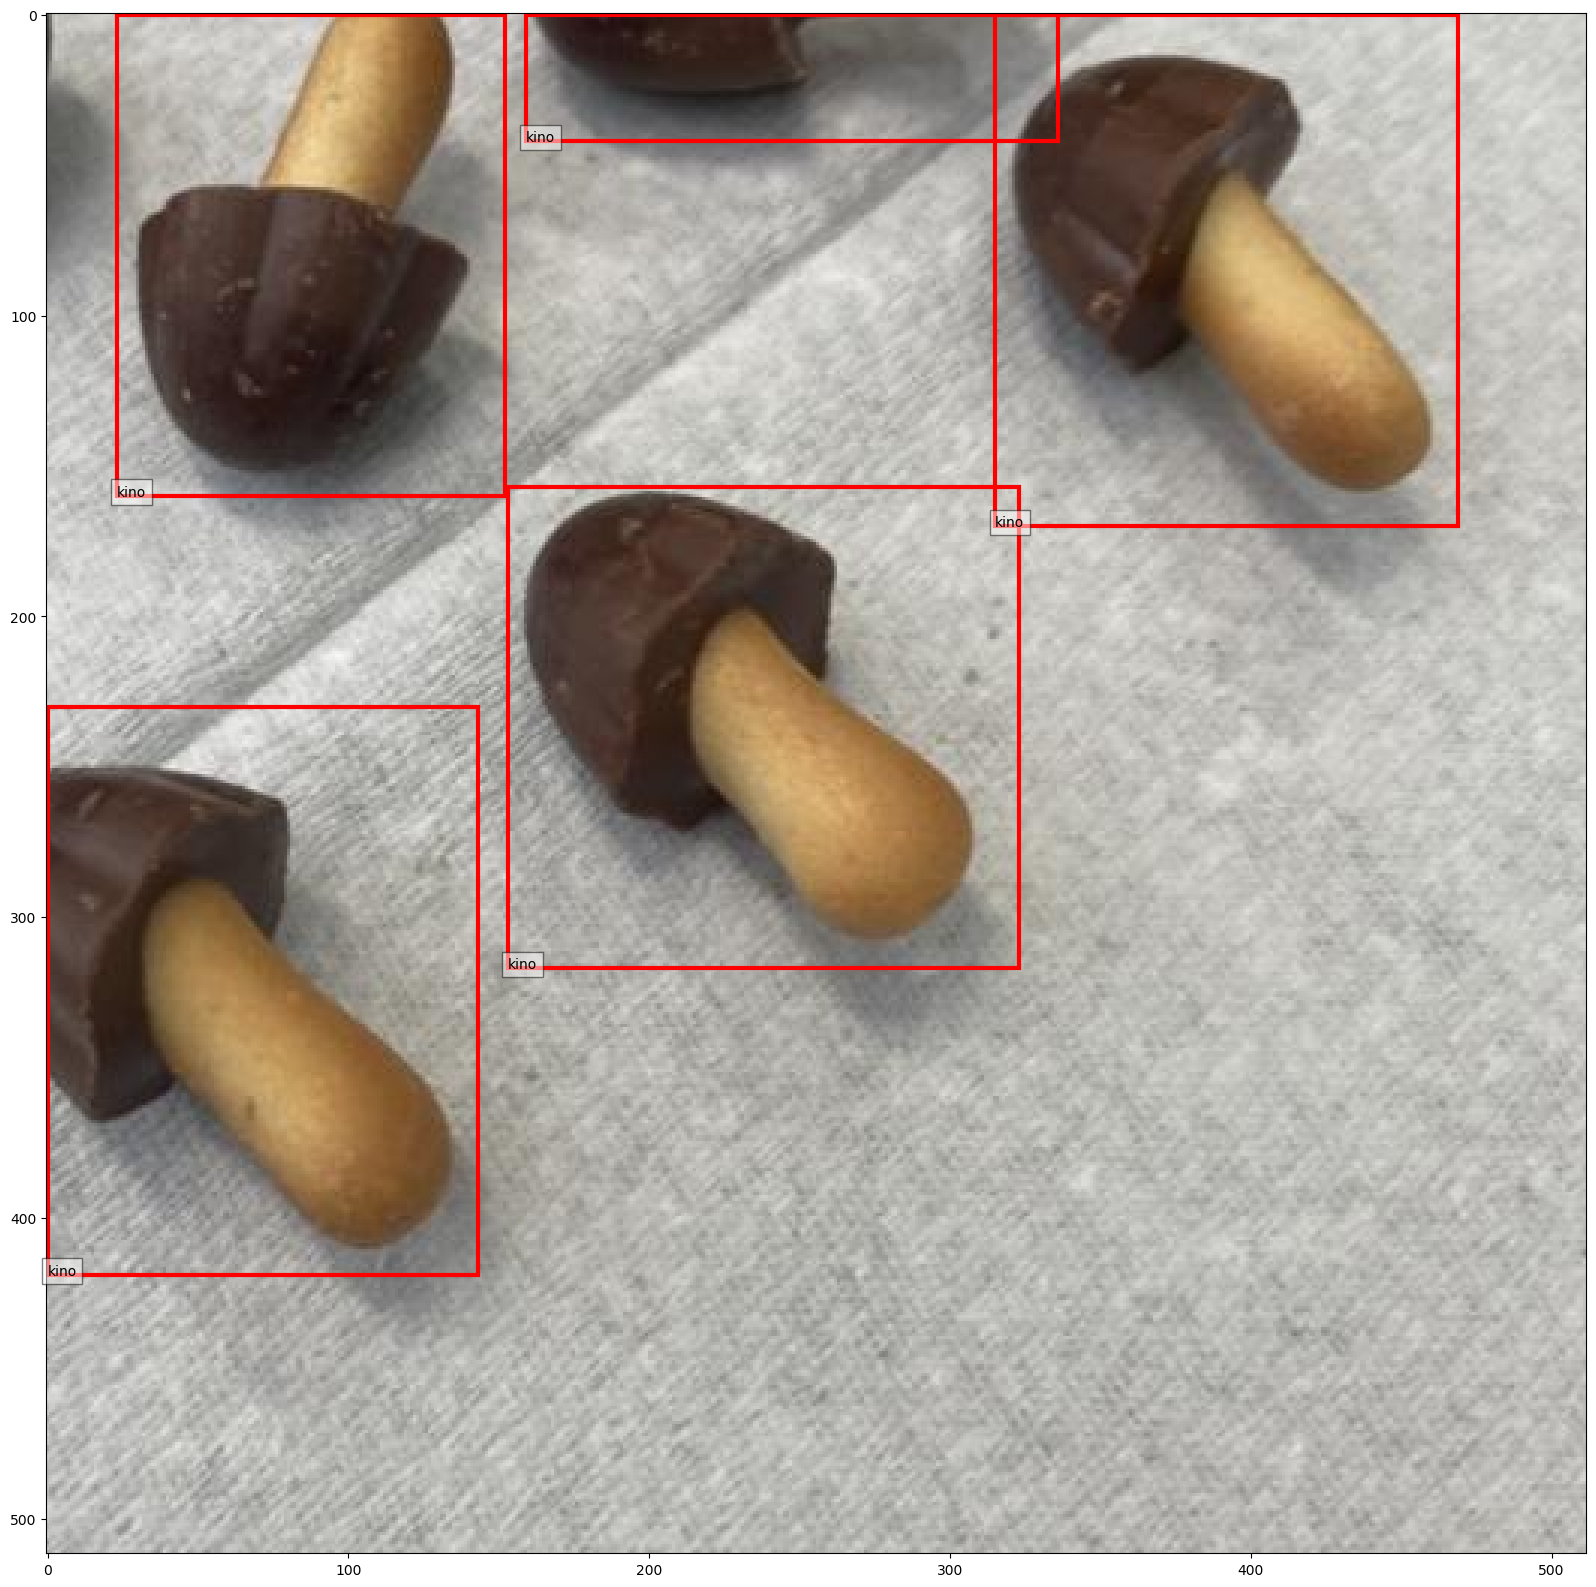

In [105]:
# 入力画像確認
FILE_NAME = '00082_00002_32928BBF-99B8-4F05-ACB6-2599C9554A63_1_105_c.jpeg'
INPUT_IMAGE_FILE = f'{OUTPUT_DIR}{FILE_NAME}'
print(INPUT_IMAGE_FILE)
# 推論対象の画像を開いて変数に格納
with open(INPUT_IMAGE_FILE, 'rb') as f:
    img_bin = f.read()

# ラベリング結果(json)を読み込む
with open('annotations.json') as f:
    annotations_json = json.load(f)

image_id = 0
plt.clf()
plt.close()

# 対象イメージを特定
for annotations_image in annotations_json['images']:
    if annotations_image['file_name'] == FILE_NAME:
        print(annotations_image)
        image_id = annotations_image['id']

image_np = np.array(Image.open(INPUT_IMAGE_FILE))
# matplotlibで描画する
fig = plt.figure(figsize=(20,20))
ax = plt.axes()
ax.imshow(image_np)
# イメージに対するアノテーションを取得
for annotations_row in annotations_json['annotations']:
    if annotations_row['image_id'] == image_id:
        # 検出した座標（左上を(0,0),右下を(1,1)とした相対座標)を取得
        left, top, right, bot = annotations_row['bbox']
         # 相対座標を絶対座標に変換する
        x = left
        w = right - left
        y = bot
        h = top - bot
         # 検出した物体の ID を take/kino に読み替える
        class_name = 'kino' if int(annotations_row['category_id'])==0 else 'take'
         # take/kinoに対して矩形で描画するための色を設定する
        color = 'blue' if class_name == 'take' else 'red'
         # matplotlib に検出した物体に矩形を描画する
        rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        # 左上に検出結果と信頼度スコアを描画する
        # ax.text(x, y, "{} {:.0f}%".format(class_name, 0), bbox=dict(facecolor='white', alpha=0.5))
        ax.text(x, y, "{}".format(class_name), bbox=dict(facecolor='white', alpha=0.5))

fig

### 9-2. ベルトコンベアを模した推論
* `./traning-test_raw_images/takenoko.jpg` にタケノコが横一列に並んでいる（１つだけキノコが混在）
* 512x512の画像をスライドしながら切り出すことでベルトコンベアでお菓子が流れているような動画として扱う
* 各画像に対して推論をかけ、最後に１つの動画として出力する

In [113]:
%%time
# 画像を切り出すためのコード
# 開始地点設定
x ,y = 0,512
# 切り出すサイズ設定
CROP_SIZE=(512,512)
# 切り出す対象の画像を PIL で開く
img = Image.open('./traning-test_raw_images/takenoko.jpg')
# 切り出した画像を保存するディレクトリ
CROP_DIR = './traning-test_crop_images/'
# re-run 用の削除コマンド
!rm -rf {CROP_DIR}/*.png
# 1pxずらしてループ
for i in range(img.size[0]-CROP_SIZE[0]):
    # 画像の切り出し
    crop_img = img.crop((i,y,i+CROP_SIZE[0],y+CROP_SIZE[1]))
    # 切り出した画像を保存
    file_name = f'{CROP_DIR}{str(i).zfill(5)}.png'
    crop_img.save(file_name)

CPU times: user 4min 36s, sys: 1.31 s, total: 4min 38s
Wall time: 6min 40s


全データ推論して、矩形を描いた画像を生成する

In [ ]:
%%time
# 検出結果を保存するディレクトリを設定
DETECT_DIR='./traning-test_detect_images/'
# re-run 用の削除コマンド
!rm -rf {DETECT_DIR}/*.png

# 切り出した画像分だけループ
for img_file_path in sorted(glob(f'{CROP_DIR}*.png')):
    # 切り出した画像を開く
    with open(img_file_path,'rb') as f:
        img_bin = f.read()
    # 推論エンドポイントに画像を投げる
    response = smr_client.invoke_endpoint(EndpointName=ENDPOINT_NAME, ContentType='application/x-image', Body=img_bin)
    # 推論結果を読み込む
    pred=json.loads(response['Body'].read())
    # 推論結果を展開
    bboxes, classes, confidences = pred['normalized_boxes'], pred['classes'], pred['scores']
    # 切り出した画像を PIL で開く
    img = Image.open(img_file_path)
    # 矩形やテキストを描くために draw インスタンスを生成
    draw = ImageDraw.Draw(img)
    # 検出したkino/take分ループ
    for i in range(len(bboxes)):
        # 信頼度スコアが0.8以上のみ描画する
        if confidences[i]>0.8:
            # 矩形の相対座標を取得
            left, top, right, bottom = bboxes[i]
            # 矩形の相対座標を絶対座標に変換
            left = img.size[0] * left
            top = img.size[1] * top
            right = img.size[0] * right
            bottom = img.size[1] * bottom
            # 検出した物体の ID を take/kino に読み替える
            text = 'take' if int(classes[i])==1 else 'kino'
            # take/kinoに対して矩形で描画するための色を設定する
            color = 'blue' if text == 'take' else 'red'
            # 矩形の左上に表示する文字の大きさを設定、きのこの山なら大きくする
            TEXTSIZE=14 if classes[i]=='1' else 18
            # 矩形の先の太さを設定、きのこの山なら太くする
            LINEWIDTH=4 if classes[i]=='1' else 6
            # 矩形を描画する
            draw.rectangle([(left,top),(right,bottom)], outline=color, width=LINEWIDTH)
            # 矩形の左上に描画する信頼度スコアの取得
            text += f' {str(round(confidences[i],3))}'
            # テキストを描画する場所を取得
            txpos = (left, top-TEXTSIZE-LINEWIDTH//2)
            # フォントの設定
            font = ImageFont.truetype("/usr/share/fonts/truetype/noto/NotoMono-Regular.ttf", size=TEXTSIZE)
            # 描画するテキストのサイズを取得
            txw, txh = draw.textsize(text, font=font)
            # テキストの背景用の矩形を描画
            draw.rectangle([txpos, (left+txw, top)], outline=color, fill=color, width=LINEWIDTH)
            # テキストを描画
            draw.text(txpos, text, fill='white',font=font)
    # 画像をファイルに書き出す
    img.save(img_file_path.replace(CROP_DIR,DETECT_DIR))